In [1]:
%load_ext autoreload
%autoreload 2

# Preprompt and grammar

In [2]:
with open("../benchmark/grammars/us_lpm_grammar.lark", "r") as f:
    grammar = f.read()

In [3]:
def make_preamble(constructor):
    return f"""Your goal is to translate user questions into conditional probability statements relating the variables mentioned in the query.


Statements should take the form "{constructor('X','Y')}" where X is one of the following variables and Y one or a list of multiple variables. The grammar used is the following:

```
{grammar}
```

The variables X and Y should be closely related to the entities mentioned in the user query.

Here are some examples of user queries and paired translations:

"""

def make_prompt(preamble, example_pairs, eos=None):
    examples = '\n\n'.join([f"Q: {nl}\nA: {fl}{f' {eos}' if eos is not None else ''}" for (nl,fl) in example_pairs]) + "\n\nQ: {user_query}\nA:"
    return preamble + examples  

def make_example_pairs(constructor):
    return [
        ("How does someone's age affect their income?", 
         constructor("Total_income", ["Age"])),
        ("How does someone's credit rating affect whether or not they are conservative?", 
         constructor("Political_ideology = 'Likely Conservative'", ["Credit_rating"])),
        ("How does someone's credit rating and race affect whether or not they are conservative? ", 
         constructor("Political_ideology = 'Likely Conservative'", ["Credit_rating", "Race"])),
         ("How does the probability that someone is conservative change by income?",
           constructor("Political_ideology = 'Likely Conservative'", ["Total_income"])),
    ]

constructor = lambda event, conditioners : f"probability of {event} given {', '.join(conditioners)}"

pre_prompt = make_prompt(
    preamble=make_preamble(constructor), 
    example_pairs=make_example_pairs(constructor), 
    eos=None
)

# Test cases

In [4]:
def make_test_cases(constructor):
    return [
        ("How does someone's education affect their credit rating?", 
         constructor("Credit_rating", ["Education"])),
        ("What's the relationship between someone's income and how likely they are to be conservative?", 
         constructor("Political_ideology = 'Likely Conservative'", ["Total_income"])),
        ("What's the relationship between someone's income and religiosity how likely they are to be conservative?", 
         constructor("Political_ideology = 'Likely Conservative'", ["Total_income", "Religious_inspiration"])),
        ("What's the relationship between someone's income and race how likely they are to be conservative?", 
         constructor("Political_ideology = 'Likely Conservative'", ["Total_income", "Race"])),
        ("What's the relationship between someone's income and their commute time?", 
         constructor("Commute_minutes", ["Total_income"])),
        ("How does the probability that someone has no commute time change with age?", 
         constructor("Commute_minutes = '(a) no commute'", ["Age"]))
    ]

import re

def normalize_string(string):
    return re.sub(r'^\s+', '', re.sub(r"▪|</s>", '', string))

def are_equal_up_to_ws(str1, str2):
    return re.sub(r'\n|\s+', '', str1) == re.sub(r'\n|\s+', '', str2)

In [5]:
test_cases = make_test_cases(constructor)

# Inference

In [6]:
from genparse.util import lark_guide
# two guides to isolate caches
guide_s = lark_guide(grammar)
guide_p = lark_guide(grammar)

from genparse.experimental.batch_inference import BatchVLLM
batch_llm = BatchVLLM.from_name('meta-llama/Meta-Llama-3-8B')

/home/lebrunb/miniconda3/envs/genparse3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-25 03:01:50,647	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 07-25 03:01:56 llm_engine.py:161] Initializing an LLM engine (v0.5.0.post1) with config: model='meta-llama/Meta-Llama-3-8B', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3-8B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=meta-llama/Meta-Llama-3-8B)
INFO 07-25 03:01:57 weight_utils.py:218] Using model weights format ['*.safetensors']
INFO 07-25 03:02:02 model_runner.py:160] Loading model weights took 14.9595 GB
INFO 07-25 03:02:03 gpu_executor.py:83] # GPU blocks: 9638, # CPU blocks: 2048
INFO 07-25 03:02:05 model_runner.p

In [10]:
from genparse.experimental.batch_inference import ParallelCharacterProposal, CharacterBatchProposal
import multiprocessing as mp

parallel_proposal = ParallelCharacterProposal(
    llm=batch_llm.llm, guide=guide_p, num_processes=4, max_n_particles=350, seed=0
)

sequential_proposal = CharacterBatchProposal(llm=batch_llm.llm, guide=guide_s)

Initialized parallel batch proposal with num_processes=4, max_n_particles=350, seed=0


In [11]:
from genparse.experimental.batch_inference import BatchStepModel
parallel_step_model = BatchStepModel(batch_proposal=parallel_proposal, batch_llm=batch_llm, max_tokens=50)
sequential_step_model = BatchStepModel(batch_proposal=sequential_proposal, batch_llm=batch_llm, max_tokens=50)

Initialized batch stepper with eos=▪ and max_tokens=50
Initialized batch stepper with eos=▪ and max_tokens=50


In [12]:
from genparse.util import set_seed
set_seed(0)

In [13]:
from genparse.experimental.batch_inference import smc
parallel_step_model.set_prompt(pre_prompt.format(user_query="How does someone's age affect their income?"))
parallel_approx = smc(parallel_step_model, n_particles=100)
parallel_approx

key,value
probability of Total_income given Age ▪,0.9510644090075745
probability of Age given Total_income ▪,0.04047507469366638
"probability of Total_income given Age, Total_income ▪",0.0017511456270283775
"probability of Total_income given Age, Sex ▪",0.0009500423954810714
probability of Total_income given Age = 65 ▪,0.0007121239457054661
"probability of Total_income given Age, Age ▪",0.0006870582702099076
"probability of Total_income given Age, World_region_of_birth ▪",0.000584938007796685
"probability of Total_income given Age, Childrens_learning_toys ▪",0.0005420281868581927
probability of Total_income given Age = 50 ▪,0.0003886401295972616
probability of Total_income given Age = 45 ▪,0.0003795111008031336


In [14]:
from genparse.experimental.batch_inference import smc
sequential_step_model.set_prompt(pre_prompt.format(user_query="How does someone's age affect their income?"))
sequential_approx = smc(sequential_step_model, n_particles=100)
sequential_approx

key,value
probability of Total_income given Age ▪,0.9783125262627653
probability of Age given Total_income ▪,0.011936085523177884
"probability of Total_income = '(n) $75,000 - $99,999' ▪",0.008085036112164339
probability of Total_income given Age = 70 ▪,0.0012043464523544079
"probability of Total_income = '(k) $55,000 - $59,999' given Age = 20 ▪",0.0004502654415353843
"probability of Total_income = '(s) $250,000 Plus' given Age ▪",6.873591452342132e-06
"probability of Total_income = '(g) $35,000 - $39,999' given Age ▪",4.449758617139359e-06
probability of Total_income given Age = 40 ▪,4.1685793284942714e-07
probability of Insurance_purchased_directly given Age ▪,2.8840283361905027e-16
probability of Investments given Age ▪,1.2999845870069232e-19


In [15]:
assert sequential_approx.posterior.argmax() == parallel_approx.posterior.argmax()

# Benchmarking

In [16]:
from arsenal.timer import Benchmark

n_processes = parallel_step_model.batch_proposal.num_processes

T = Benchmark(f'Parallel vs Sequential run time on question/answering demo test cases\n (smc, {n_processes=}, character proposal, Llama 3)')

for n_particles in [10, 20, 40, 50]:

    for i, (test_case, _) in enumerate(test_cases):
        parallel_step_model.set_prompt(pre_prompt.format(user_query=test_case))
        sequential_step_model.set_prompt(pre_prompt.format(user_query=test_case))

        with T['parallel proposal'](i=i, n_particles=n_particles):
            parallel_approx = smc(parallel_step_model, n_particles=n_particles)

        with T['sequential proposal'](i=i, n_particles=n_particles):
            sequential_approx = smc(sequential_step_model, n_particles=n_particles)

        want = parallel_approx.posterior.argmax()
        have = sequential_approx.posterior.argmax()

        if not want == have:
            print(repr(test_case), n_particles, repr(want), repr(have))


"What's the relationship between someone's income and their commute time?" 10 ' probability of Commute_minutes given Total_income\n▪' ' probability of Means_of_transportation given Total_income\n▪'
'How does the probability that someone has no commute time change with age?' 10 " probability of Means_of_transportation = 'Drove alone' given Age\n▪" " probability of Commute_minutes = '(a) no commute' given Age\n▪"
'How does the probability that someone has no commute time change with age?' 20 " probability of Means_of_transportation = 'Drove alone' given Age\n▪" " probability of Commute_minutes = '(a) no commute' given Age\n▪"


In [24]:
parallel_proposal.cleanup()
sequential_proposal.cleanup()

In [30]:
import time
n_processes = parallel_step_model.batch_proposal.num_processes

T = Benchmark('Parallel vs Sequential run time on question/answering demo test cases\n (smc, character proposal, Llama 3)')

for n_processes in [2, 4, 8, 10, 12]:

    for n_particles in [10, 30, 50, 80]:

        parallel_proposal = ParallelCharacterProposal(
            llm=batch_llm.llm, guide=guide_p, num_processes=n_processes, max_n_particles=350, seed=0
        )
        parallel_step_model = BatchStepModel(batch_proposal=parallel_proposal, batch_llm=batch_llm, max_tokens=50)

        time.sleep(5)

        for i, (test_case, _) in enumerate(test_cases):
            parallel_step_model.set_prompt(pre_prompt.format(user_query=test_case))
            sequential_step_model.set_prompt(pre_prompt.format(user_query=test_case))

            with T['sequential proposal'](i=i, n_particles=n_particles, n_processes=n_processes):
                sequential_approx = smc(sequential_step_model, n_particles=n_particles)

            with T['parallel proposal'](i=i, n_particles=n_particles, n_processes=n_processes):
                parallel_approx = smc(parallel_step_model, n_particles=n_particles)

    parallel_proposal.cleanup()
    sequential_proposal.cleanup()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initialized parallel batch proposal with num_processes=2, max_n_particles=350, seed=0
Initialized batch stepper with eos=▪ and max_tokens=50


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initialized parallel batch proposal with num_processes=2, max_n_particles=350, seed=0
Initialized batch stepper with eos=▪ and max_tokens=50


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initialized parallel batch proposal with num_processes=2, max_n_particles=350, seed=0
Initialized batch stepper with eos=▪ and max_tokens=50


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initialized parallel batch proposal with num_processes=2, max_n_particles=350, seed=0
Initialized batch stepper with eos=▪ and max_tokens=50


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Initialized parallel batch proposal with num_processes=4, max_n_particles=350, seed=0
Initialized batch stepper with eos=▪ and max_tokens=50


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Initialized parallel batch proposal with num_processes=4, max_n_particles=350, seed=0
Initialized batch stepper with eos=▪ and max_tokens=50


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Initialized parallel batch proposal with num_processes=4, max_n_particles=350, seed=0
Initialized batch stepper with eos=▪ and max_tokens=50


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Initialized parallel batch proposal with num_processes=4, max_n_particles=350, seed=0
Initialized batch stepper with eos=▪ and max_tokens=50


In [20]:
T.compare()

parallel proposal is 4.4456x faster than sequential proposal (p=0.00000, median: sequential proposal: 17.3686, parallel proposal: 3.90693)


<Axes: title={'center': 'Parallel vs Sequential run time on question/answering demo test cases\n (smc, n_processes=4, character proposal, Llama 3)'}, xlabel='n_particles', ylabel='time (seconds)'>

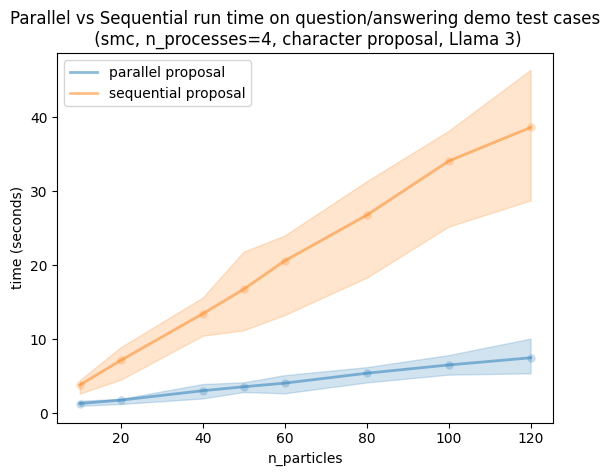

In [21]:
T.plot_feature('n_particles')

<Axes: title={'center': 'Parallel vs Sequential run time on question/answering demo test cases\n (smc, n_processes=12, character proposal, Llama 3)'}, xlabel='n_particles', ylabel='time (seconds)'>

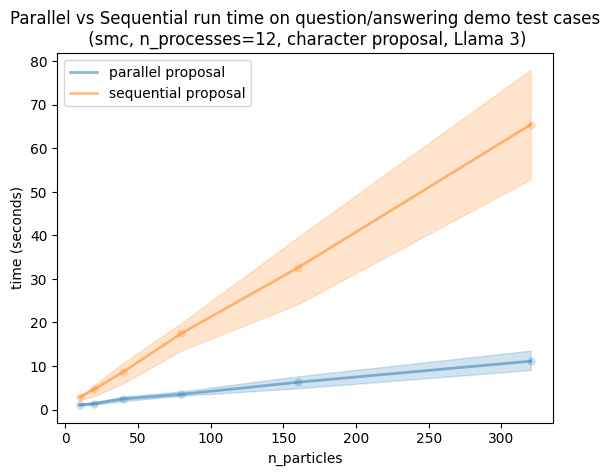

In [29]:
T.plot_feature('n_particles')